In [2]:
import numpy as np
from numpy import pi, cos, sin, log, sqrt

import matplotlib.pyplot as plt
from matplotlib import cm

# Reloading the module
import importlib

import Nodal2D
importlib.reload(Nodal2D)
from Nodal2D import *

import Curve
importlib.reload(Curve)
from Curve import *

import MappingGeometry2D
importlib.reload(MappingGeometry2D)
from MappingGeometry2D import *

import Potential2D
importlib.reload(Potential2D)
from Potential2D import *

## Boundary curves

In [3]:
# Inner and outer radius
a = 1
b = 3

In [4]:
# Creating curve1
# Create a curve class
c1 = Curve2D(N=10)
# Set boundary parameter points to be Legendre Gauss Lobbato points
c1.set_parameter_points(point_type="Legendre")
c1.set_BarycentricWeights()
c1.set_DiffMatrix()

# Parameter range
par_range = np.array([-1,1])
x_start = a
y_start = 0
x_end = b
y_end = 0


def x(t):
    return (x_start * (1-t) + x_end * (1+t))/2

def y(t):
    return (y_start * (1-t) + y_end * (1+t))/2

def x_deri(t):
    return (x_end - x_start)/2

def y_deri(t):
    return (y_end - y_start)/2

c1.reparameterization(x, y, x_deri, y_deri, par_range)
c1.cal_derivatives_node()

In [5]:
# Creating curve2
# Create a curve class
c2 = Curve2D(N=20)
# Set boundary parameter points to be Legendre Gauss Lobbato points
c2.set_parameter_points(point_type="Chebyshev")
c2.set_BarycentricWeights()
c2.set_DiffMatrix()

# Parameter range
par_range = np.array([0, pi/2])



def x(t):
    return b * cos(t)

def y(t):
    return b * sin(t)

def x_deri(t):
    return - b * sin(t)

def y_deri(t):
    return b * cos(t)

c2.reparameterization(x, y, x_deri, y_deri, par_range)
c2.cal_derivatives_node()

In [6]:
# Creating curve3
# Create a curve class
c3 = Curve2D(N=10)
# Set boundary parameter points to be Legendre Gauss Lobbato points
c3.set_parameter_points(point_type="Legendre")
c3.set_BarycentricWeights()
c3.set_DiffMatrix()

# Parameter range
par_range = np.array([-1,1])
x_start = 0
y_start = a
x_end = 0
y_end = b


def x(t):
    return (x_start * (1-t) + x_end * (1+t))/2

def y(t):
    return (y_start * (1-t) + y_end * (1+t))/2

def x_deri(t):
    return (x_end - x_start)/2

def y_deri(t):
    return (y_end - y_start)/2

c3.reparameterization(x, y, x_deri, y_deri, par_range)
c3.cal_derivatives_node()

In [7]:
# Creating curve4
# Create a curve class
c4 = Curve2D(N=20)
# Set boundary parameter points to be Legendre Gauss Lobbato points
c4.set_parameter_points(point_type="Chebyshev")
c4.set_BarycentricWeights()
c4.set_DiffMatrix()

# Parameter range
par_range = np.array([0, pi/2])

def x(t):
    return a * cos(t)

def y(t):
    return a * sin(t)

def x_deri(t):
    return - a * sin(t)

def y_deri(t):
    return a * cos(t)

c4.reparameterization(x, y, x_deri, y_deri, par_range)
c4.cal_derivatives_node()

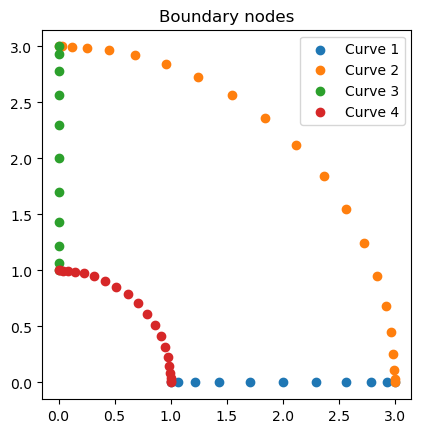

In [8]:
# Collecting the boundary curves
curves = [c1, c2, c3, c4]

# Testing the geometry
fig, ax = plt.subplots(nrows=1, ncols=1)
for i, c in enumerate(curves):
    ax.scatter(c.x_nodes, c.y_nodes, label='Curve {}'.format(i+1))
ax.legend()
ax.set_title('Boundary nodes')
ax.set_aspect('equal')

## Nodes

In [9]:
N = 20
M = 22
nodal2D = Nodal2D(N,M)
nodal2D.cal_nodes(node_type_x="Legendre", node_type_y="Legendre")
nodal2D.cal_BarycentricWeights()
nodal2D.cal_DiffMatrix()

## Mapping

In [10]:
# Initialize the mapping
mg = MappingGeometry2D(nodal2D=nodal2D, curves=curves)
# Calculating the physical nodes
mg.cal_Map_nodes()
# Calculating the node derivatives
mg.cal_MapDerivatives_nodes()
# Calculating the node Jacobian
mg.cal_Jacobian()
# Calculating the normal vectors on the boundary
mg.cal_normal_vector_nodes()

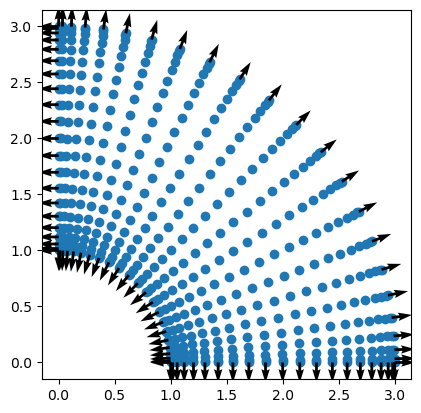

In [11]:
# Visualizing the nodes and the normal vectors
fig, ax = plt.subplots(nrows=1, ncols=1)
Nx = mg.nodal2D.Nx
Ny = mg.nodal2D.Ny

ax.scatter(mg.nodes_phy_x, mg.nodes_phy_y)

j = 0
ax.quiver(mg.nodes_phy_x[:,j], mg.nodes_phy_y[:,j], 
              mg.norm_vect_lower[:,0], mg.norm_vect_lower[:,1])
    
j = Ny   
ax.quiver(mg.nodes_phy_x[:,j], mg.nodes_phy_y[:,j], 
              mg.norm_vect_upper[:,0], mg.norm_vect_upper[:,1])    

i = 0
ax.quiver(mg.nodes_phy_x[i,:], mg.nodes_phy_y[i,:], 
              mg.norm_vect_left[:,0], mg.norm_vect_left[:,1])

i = Nx
ax.quiver(mg.nodes_phy_x[i,:], mg.nodes_phy_y[i,:], 
              mg.norm_vect_right[:,0], mg.norm_vect_right[:,1])   

ax.set_aspect('equal')

## Solving the system

In [12]:
# Compute the source terms
# The exact solution is u = ln(r) sin(4 theta)
# s = -16 ln(r) / r^2 sin(4 theta)
S = np.zeros((mg.nodal2D.Nx+1, mg.nodal2D.Ny+1))
for i in range(mg.nodal2D.Nx+1):
    for j in range(mg.nodal2D.Ny+1):
        x = mg.nodes_phy_x[i,j]
        y = mg.nodes_phy_y[i,j]
        r = sqrt(x**2 + y**2)
        theta = np.angle(x + 1j * y)
        S[i,j] = -16 * log(r) / r**2 * sin(4*theta)

In [13]:
# Initializing the solution matrix
U = np.zeros((mg.nodal2D.Nx+1, mg.nodal2D.Ny+1))
# Compute the boundary values
# The exact solution is u = ln(r) sin(4 theta)

for j in [0, mg.nodal2D.Ny]:
    for i in range(mg.nodal2D.Nx+1):
        x = mg.nodes_phy_x[i,j]
        y = mg.nodes_phy_y[i,j]
        r = sqrt(x**2 + y**2)
        theta = np.angle(x + 1j * y)
        U[i,j] = log(r) * sin(4*theta)
        
        
for i in [0, mg.nodal2D.Nx]:
    for j in range(mg.nodal2D.Ny+1):
        x = mg.nodes_phy_x[i,j]
        y = mg.nodes_phy_y[i,j]
        r = sqrt(x**2 + y**2)
        theta = np.angle(x + 1j * y)
        U[i,j] = log(r) * sin(4*theta)

In [14]:
# Preparing coefficients
coeff_xi = (mg.X_xi**2 + mg.Y_xi**2) / mg.J
coeff_eta = (mg.X_eta**2 + mg.Y_eta**2) / mg.J
coeff_mixed = (mg.X_xi * mg.X_eta + mg.Y_xi * mg.Y_eta) / mg.J
# Constructing RHS
RHS = cal_RHS(D_xi=mg.nodal2D.Dx,
              D_eta=mg.nodal2D.Dy,
              J=mg.J,
              coeff_xi=coeff_xi,
              coeff_eta=coeff_eta,
              coeff_mixed=coeff_mixed,
              U=U,
              S=S,
              N=mg.nodal2D.Nx,
              M=mg.nodal2D.Ny)
# Constructing the extended system: Cx = d
C, d = MatEqnConverter_NonsquareCollocation_Dirichlet(D_xi=mg.nodal2D.Dx,
                                                      D_eta=mg.nodal2D.Dy,
                                                      J=mg.J,
                                                      coeff_xi=coeff_xi,
                                                      coeff_eta=coeff_eta,
                                                      coeff_mixed=coeff_mixed,
                                                      RHS=RHS,
                                                      N=mg.nodal2D.Nx,
                                                      M=mg.nodal2D.Ny)

In [15]:
# Solving the system
U[1:mg.nodal2D.Nx, 1:mg.nodal2D.Ny] = MatEqnSolver_NonsquareCollocation(C=C, 
                                                                        d=d, 
                                                                        N=mg.nodal2D.Nx,
                                                                        M=mg.nodal2D.Ny)

In [16]:
# Comparing with the exact solution
# The exact solution is u = ln(r) sin(4 theta)
r_mesh = sqrt(mg.nodes_phy_x**2 + mg.nodes_phy_y**2)
theta_mesh = np.angle(mg.nodes_phy_x + 1j * mg.nodes_phy_y)
U_th = log(r_mesh) * sin(4 * theta_mesh)
print("Error:", np.max(np.abs(U-U_th)))

Error: 1.4099832412739488e-14


Text(0.5, 0.92, 'Theretical')

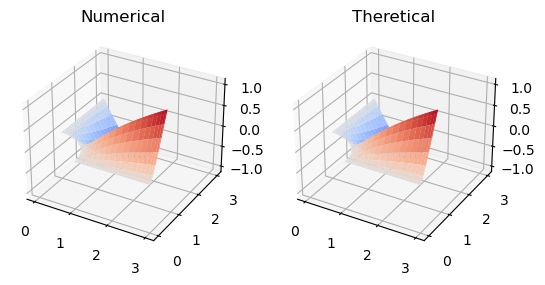

In [17]:
# Visualization
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d"})
ax[0].plot_surface(mg.nodes_phy_x, mg.nodes_phy_y, U, cmap=cm.coolwarm)
ax[1].plot_surface(mg.nodes_phy_x, mg.nodes_phy_y, U_th, cmap=cm.coolwarm)

ax[0].set_title("Numerical")
ax[1].set_title("Theretical")

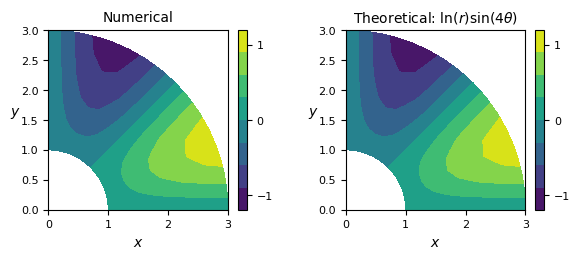

In [22]:
# Visualization
fig, ax = plt.subplots(nrows=1, ncols=2)
ct_numerical = ax[0].contourf(mg.nodes_phy_x, mg.nodes_phy_y, U)
ct_th = ax[1].contourf(mg.nodes_phy_x, mg.nodes_phy_y, U_th)


# Colorbars
# Calculate ratio to adjust the colorbar size
ct_ratio = mg.nodal2D.Nx / mg.nodal2D.Ny
cb_numerical = fig.colorbar(ct_numerical, ax=ax[0], fraction=0.05*ct_ratio, ticks=[-1,0,1])
cb_th = fig.colorbar(ct_th, ax=ax[1], fraction=0.05*ct_ratio, ticks=[-1,0,1])
# Change the tick label size
cb_tick_label_size = 8
cb_numerical.ax.tick_params(labelsize=cb_tick_label_size)
cb_th.ax.tick_params(labelsize=cb_tick_label_size)

# x,y labels
label_size = 10
for i in range(2):
    ax[i].set_xlabel(r'$x$', fontsize=label_size)
    ax[i].set_ylabel(r'$y$', rotation=0, fontsize=label_size)
    
# Tick labels
tick_label_size = 8
for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=tick_label_size)
    ax[i].tick_params(axis='both', which='minor', labelsize=tick_label_size)

# Titles
title_size = 10
ax[0].set_title("Numerical", fontsize=title_size)
ax[1].set_title("Theoretical: "+r'$\ln(r) \sin(4\theta)$', fontsize=title_size)


# Shape adjustment
# Aspect ratio
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
# Hozirontal spacing
fig.subplots_adjust(wspace=0.5)  # Adjust the horizontal spacing

# Save figure
filename = "./2D_Potential_Nonsquare_Collocation/curved_domain_.jpg"
fig.savefig(filename, dpi=600, bbox_inches="tight")